# Vehicle CO2 Emission predictor

REMEMBER TO USE FLASHCARD ANALOGY

X IS FRONT OF FLASH CARD(picture of chicken) AND THE Y IS THE ANSWER ON THE BACK OF FLASH CARD(word "chicken")

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV  # [tuning]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import joblib

In [67]:
# Load the dataset from a CSV file
data = pd.read_csv('vehicle_emissions.csv')
print(data.head())

   Model_Year   Make              Model Vehicle_Class  Engine_Size  Cylinders  \
0        2021  Acura                ILX       Compact          2.4          4   
1        2021  Acura                NSX    Two-seater          3.5          6   
2        2021  Acura         RDX SH-AWD    SUV: Small          2.0          4   
3        2021  Acura  RDX SH-AWD A-SPEC    SUV: Small          2.0          4   
4        2021  Acura         TLX SH-AWD       Compact          2.0          4   

  Transmission  Fuel_Consumption_in_City(L/100 km)  \
0          AM8                                 9.9   
1          AM9                                11.1   
2         AS10                                11.0   
3         AS10                                11.3   
4         AS10                                11.2   

   Fuel_Consumption_in_City_Hwy(L/100 km)  Fuel_Consumption_comb(L/100km)  \
0                                     7.0                             8.6   
1                                 

In [68]:
data.info

<bound method DataFrame.info of      Model_Year   Make              Model  Vehicle_Class  Engine_Size  \
0          2021  Acura                ILX        Compact          2.4   
1          2021  Acura                NSX     Two-seater          3.5   
2          2021  Acura         RDX SH-AWD     SUV: Small          2.0   
3          2021  Acura  RDX SH-AWD A-SPEC     SUV: Small          2.0   
4          2021  Acura         TLX SH-AWD        Compact          2.0   
..          ...    ...                ...            ...          ...   
930        2021  Volvo        XC40 T5 AWD     SUV: Small          2.0   
931        2021  Volvo        XC60 T5 AWD     SUV: Small          2.0   
932        2021  Volvo        XC60 T6 AWD     SUV: Small          2.0   
933        2021  Volvo        XC90 T5 AWD  SUV: Standard          2.0   
934        2021  Volvo        XC90 T6 AWD  SUV: Standard          2.0   

     Cylinders Transmission  Fuel_Consumption_in_City(L/100 km)  \
0            4          

In [69]:
# Separate features (X) and target variable (y)
X = data.drop(['CO2_Emissions'], axis=1) # dropping answer
y = data['CO2_Emissions']

In [70]:
# Define numerical and categorical columns
numerical_cols = [
    'Engine_Size', 'Cylinders',
    'Fuel_Consumption_in_City(L/100 km)',
    'Fuel_Consumption_in_City_Hwy(L/100 km)',
    'Fuel_Consumption_comb(L/100km)'
]
categorical_cols = ['Make', 'Model', 'Vehicle_Class', 'Transmission', 'Smog_Level']

preprocessing

In [71]:
# Pipeline for preprocessing numerical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),    #task1
    ('scaler', StandardScaler())                    #task2
])

In [72]:
# Pipeline for preprocessing categorical data
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [73]:
# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [74]:
# Final pipeline that includes preprocessing and the machine learning model
base_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())  # Default parameters are used;
                                        # can be tuned for better performance
])

Train/test split

In [75]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (748, 11), Test: (187, 11)


# Hyperparameter grid for tuning

In [76]:
param_grid = {
    # All model parameters must use the 'model__' prefix
    # (because we tune the step named 'model' inside the Pipeline).
    'model__n_estimators': [200, 400],  # number of trees in the forest
    'model__max_depth': [None, 10],     # tree depth; None = expand until all leaves are pure
    'model__min_samples_split': [2, 5], # min samples required to split an internal node
    'model__min_samples_leaf': [1, 2],  # min samples required at a leaf node
}

# RMSE is convenient for regression; sklearn expects "higher is better",
# so we use the NEGATIVE RMSE variant.
scoring  = 'neg_root_mean_squared_error'
cv_folds = 5  # 5-fold cross-validation

GridSearchCV WRAPS THE WHOLE PIPELINE

In [77]:
grid = GridSearchCV(base_pipeline, param_grid, cv=5, n_jobs=1)

In [78]:
grid.fit(X_train, y_train)  # стандартний виклик

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'model__max_depth': [None, 10], 'model__min_samples_leaf': [1, 2], 'model__min_samples_split': [2, 5], 'model__n_estimators': [200, 400]}"
,scoring,None
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [79]:
print("Best params:", grid.best_params_)
pipeline = grid.best_estimator_

Best params: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


In [80]:
#Creating prediction
y_pred = pipeline.predict(X_test) #only sees the front of flashcards

In [81]:
# Get the names of encoded categorical columns
# This is useful for interpreting the transformed feature set
encoded_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols)
print(encoded_columns)

['Make_Acura' 'Make_Alfa Romeo' 'Make_Aston Martin' 'Make_Audi' 'Make_BMW'
 'Make_Bentley' 'Make_Bugatti' 'Make_Buick' 'Make_Cadillac'
 'Make_Chevrolet' 'Make_Chrysler' 'Make_Dodge' 'Make_FIAT' 'Make_Ford'
 'Make_GMC' 'Make_Genesis' 'Make_Honda' 'Make_Hyundai' 'Make_Infiniti'
 'Make_Jaguar' 'Make_Jeep' 'Make_Kia' 'Make_Lamborghini' 'Make_Lexus'
 'Make_Lincoln' 'Make_MINI' 'Make_Maserati' 'Make_Mazda'
 'Make_Mercedes-Benz' 'Make_Mitsubishi' 'Make_Nissan' 'Make_Porsche'
 'Make_Ram' 'Make_Rolls-Royce' 'Make_Subaru' 'Make_Toyota'
 'Make_Volkswagen' 'Make_Volvo' 'Model_1500' 'Model_1500 4X4 EcoDiesel'
 'Model_1500 4X4 TRX' 'Model_1500 4X4 eTorque' 'Model_1500 Classic'
 'Model_1500 Classic 4X4' 'Model_1500 EcoDiesel'
 'Model_1500 HFE EcoDiesel' 'Model_1500 HFE eTorque' 'Model_1500 eTorque'
 'Model_228i xDrive Gran Coupe' 'Model_230i xDrive Coupe' 'Model_300'
 'Model_300 AWD' 'Model_430i xDrive Coupe' 'Model_4Runner 4WD'
 'Model_4Runner 4WD (Part-Time 4WD)' 'Model_500X AWD'
 'Model_530i xDriv

In [82]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root mean squared error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"R² Score: {r2:.4f}")  # Higher is better; 1.0 indicates perfect prediction
print(f"Root Mean Squared Error: {rmse:.2f}")  # Lower is better
print(f"Mean Absolute Error: {mae:.2f}")  # Lower is better


Model Performance Metrics:
R² Score: 0.9752
Root Mean Squared Error: 10.00
Mean Absolute Error: 3.16


In [83]:
# Print the shape of training and testing datasets for verification
print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(pd.DataFrame(X_train).head())

Training data shape: (748, 11)
Test data shape: (187, 11)
     Model_Year    Make                     Model Vehicle_Class  Engine_Size  \
408        2021     GMC               Terrain AWD    SUV: Small          1.5   
5          2021   Acura         TLX SH-AWD A-SPEC       Compact          2.0   
54         2021    Audi     SQ5 Sportback quattro    SUV: Small          3.0   
275        2021    Ford  Bronco Black Diamond 4WD    SUV: Small          2.3   
868        2021  Toyota         Camry AWD XLE/XSE      Mid-size          2.5   

     Cylinders Transmission  Fuel_Consumption_in_City(L/100 km)  \
408          4           A9                                 9.6   
5            4         AS10                                11.3   
54           6          AS8                                13.1   
275          4         AS10                                13.1   
868          4          AS8                                 9.5   

     Fuel_Consumption_in_City_Hwy(L/100 km)  Fuel_Consumpt

In [84]:
joblib.dump(pipeline, 'vehicle_emissions_pipeline.joblib')  #saving pipeline

['vehicle_emissions_pipeline.joblib']

# Pipeline load check

In [85]:
loaded_pipeline = joblib.load('vehicle_emissions_pipeline.joblib')

In [86]:
sample = pd.DataFrame([{
    'Engine_Size': 2.4,
    'Cylinders': 4,
    'Fuel_Consumption_in_City(L/100 km)': 9.9,
    'Fuel_Consumption_in_City_Hwy(L/100 km)': 7,
    'Fuel_Consumption_comb(L/100km)': 8.6,
    'Make': 'Acura',
    'Model': 'ILX',
    'Vehicle_Class': 'Compact',
    'Transmission': 'AM8',
    'Smog_Level': 3
}])
# Make,Model,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Consumption_in_City(L/100 km),Fuel_Consumption_in_City_Hwy(L/100 km),Fuel_Consumption_comb(L/100km),CO2_Emissions,Smog_Level
#
# Acura,ILX,Compact,2.4,4,AM8,9.9,7,8.6,199,3

In [87]:
pred = loaded_pipeline.predict(sample)
print("Predicted CO₂ for sample:", float(pred[0]))

Predicted CO₂ for sample: 199.695


In [88]:
sample = pd.DataFrame([{
    'Engine_Size': 2.0,
    'Cylinders': 4,
    'Fuel_Consumption_in_City(L/100 km)': 9.5,
    'Fuel_Consumption_in_City_Hwy(L/100 km)': 7.0,
    'Fuel_Consumption_comb(L/100km)': 8.3,
    'Make': 'Honda',
    'Model': 'Civic',
    'Vehicle_Class': 'Compact',
    'Transmission': 'A6',
    'Smog_Level': 2
}])

pred = loaded_pipeline.predict(sample)
print("Predicted CO₂ for sample:", float(pred[0]))

Predicted CO₂ for sample: 194.32


In [89]:
metrics = ['R²', 'RMSE', 'MAE']
values = [r2, rmse, mae]

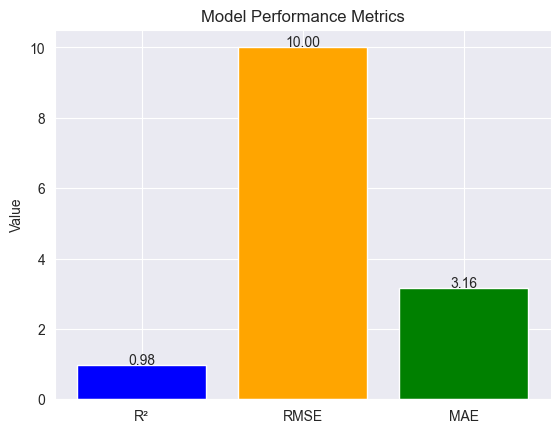

In [90]:
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.title('Model Performance Metrics')
plt.ylabel('Value')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


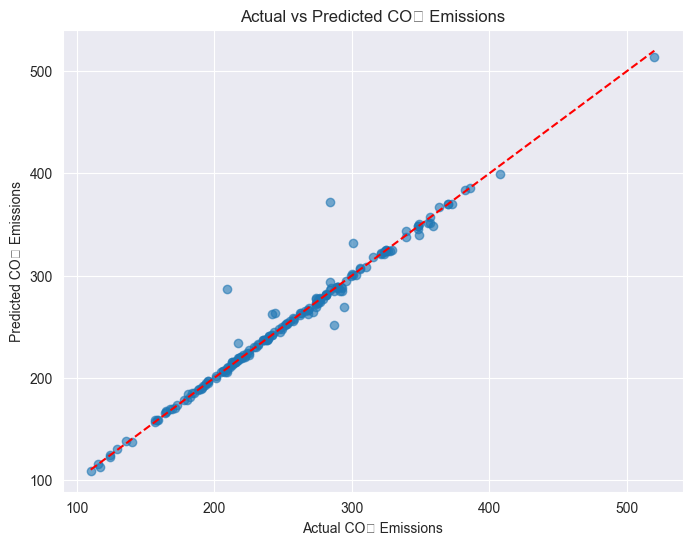

In [91]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs Predicted CO₂ Emissions')
plt.xlabel('Actual CO₂ Emissions')
plt.ylabel('Predicted CO₂ Emissions')
plt.show()

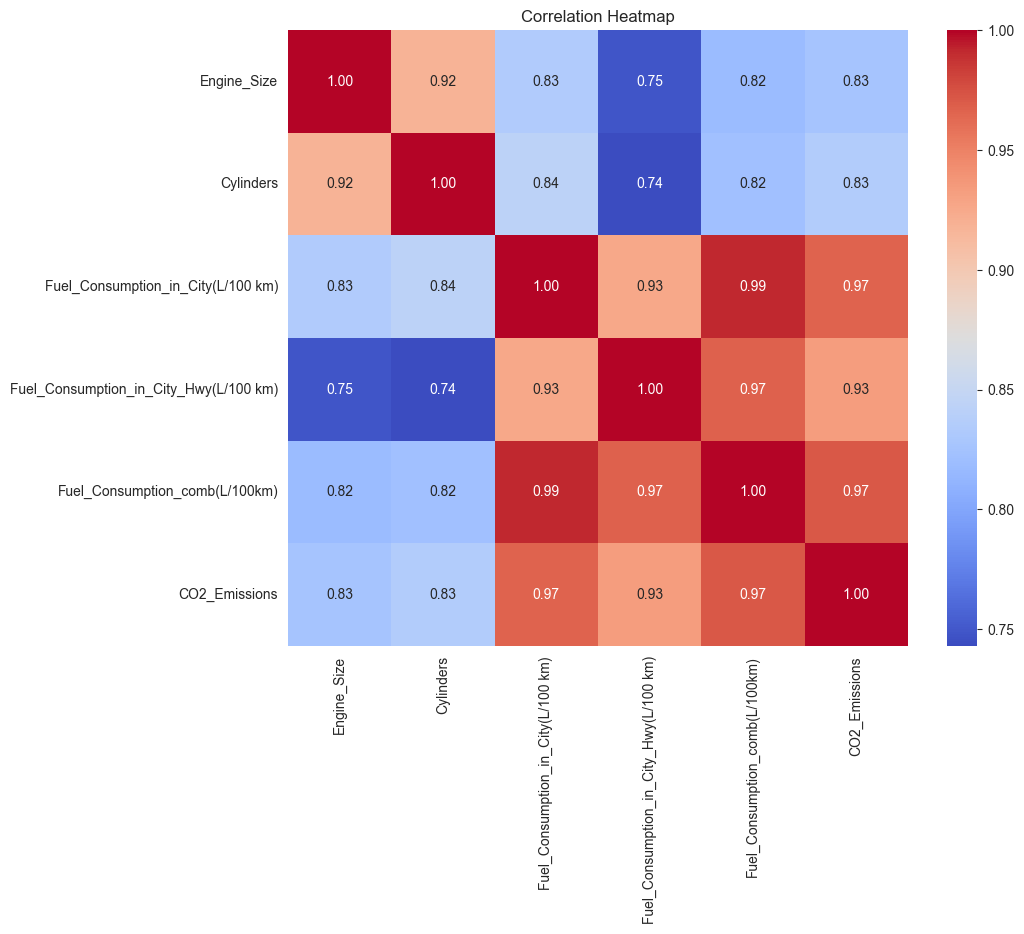

In [92]:
corr_matrix = data[numerical_cols + ['CO2_Emissions']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()